## Simple Analytics

- We now have site information across the Czech Republic, with samples, and with taxon names. 

- Let's look at the distributions of taxa across time, simply their presence absence. 

- Pick the top 20 taxa (based on the number of times they appear in the records) and look at their distributions in time

In [2]:
# Run this cell if you want to follow along 
options(warn = -1)
suppressMessages(library(neotoma2))
suppressMessages(library(sf))
suppressMessages(library(geojsonsf))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(leaflet))
suppressWarnings(library(dplyr))

options(dplyr.summarise.inform = FALSE)

### Stratigraphic Plotting with `rioja`

In [8]:
# Run this cell if you want to follow along 
cz_dl <- readRDS('data/czDownload.RDS')

# Get 1 site only
plottingSite <- cz_dl[[1]]

# select only taxa identified from pollen (and only trees/shrubs)
plottingTaxa <- taxa(plottingSite) %>%
  filter(ecologicalgroup %in% c("TRSH")) %>%
  filter(elementtype == "pollen") %>%
  arrange(desc(samples)) %>% 
  head(n = 10)

DT::datatable(head(plottingTaxa, n =2))

HTML widgets cannot be represented in plain text (need html)

In [7]:
# Select only pollen measured using NISP.
# We repeat the filters for pollen & ecological group on the samples
shortSamples <- samples(plottingSite) %>% 
  filter(variablename %in% plottingTaxa$variablename) %>% 
  filter(ecologicalgroup %in% c("TRSH")) %>%
  filter(elementtype == "pollen") %>%
  filter(units == "NISP")
DT::datatable(head(shortSamples, n=2))

HTML widgets cannot be represented in plain text (need html)

In [9]:
# Transform to proportion values.
onesite <- shortSamples %>%
  group_by(age) %>%
  mutate(pollencount = sum(value, na.rm = TRUE)) %>%
  group_by(variablename) %>% 
  mutate(prop = value / pollencount) %>% 
  arrange(desc(age))

In [10]:
# Spread the data to a "wide" table, with taxa as column headings.
widetable <- onesite %>%
  dplyr::select(age, variablename, prop) %>% 
  mutate(prop = as.numeric(prop))

counts <- tidyr::pivot_wider(widetable,
                             id_cols = age,
                             names_from = variablename,
                             values_from = prop,
                             values_fill = 0)

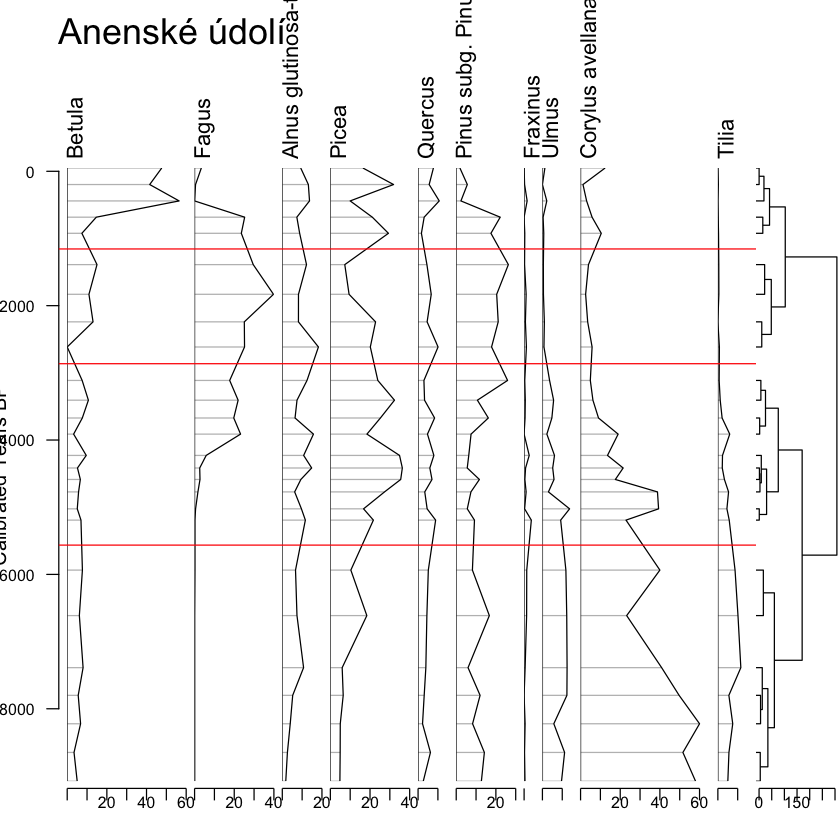

In [11]:
clust <- rioja::chclust(dist(sqrt(counts)),
                        method = "coniss")

plot <- rioja::strat.plot(counts[,-1] * 100, yvar = counts$age,
                  title = cz_dl[[1]]$sitename,
                  ylabel = "Calibrated Years BP",
                  xlabel = "Pollen (%)",
                  y.rev = TRUE,
                  clust = clust,
                  wa.order = "topleft", scale.percent = TRUE)

rioja::addClustZone(plot, clust, 4, col = "red")

## Distributions in Climate (July max temperature) from `rasters`

In [25]:
allSamp <- samples(cz_dl)

modern <- samples(cz_dl) %>% 
  filter(age < 50) %>% 
  filter(ecologicalgroup == "TRSH" & elementtype == "pollen" & units == "NISP")

spatial <- sf::st_as_sf(modern, 
                        coords = c("long", "lat"),
                        crs = "+proj=longlat +datum=WGS84")

In [26]:
worldTmax <- raster::getData('worldclim', var = 'tmax', res = 10)
spatial$tmax7 <- raster::extract(worldTmax, spatial)[,7]

In [27]:
spatial <- spatial %>%
  mutate(variablename = stringr::str_replace(variablename, "[[:punct:]]", " ")) %>% 
  mutate(variablename = stringr::word(variablename, 1)) %>% 
  group_by(variablename, siteid) %>% 
  summarise(tmax7 = max(tmax7), .groups = "keep") %>%
  group_by(variablename) %>% 
  filter(n() > 3)

In [31]:
maxsamp <- spatial %>% 
  dplyr::group_by(siteid) %>% 
  dplyr::summarise(tmax7 = max(tmax7), .groups = 'keep')

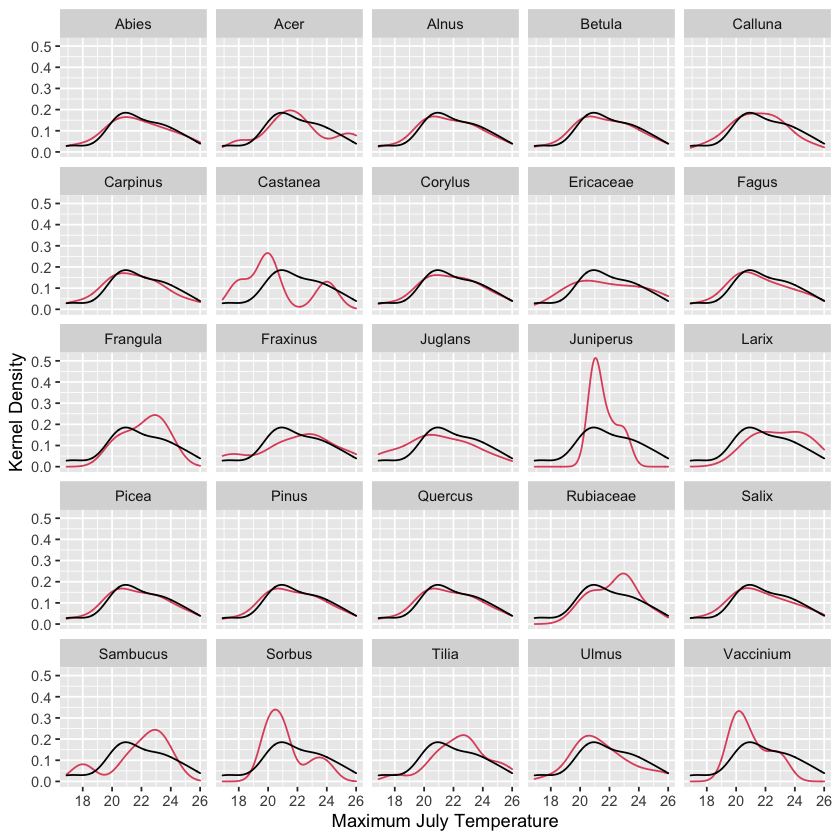

In [30]:
ggplot() +
  geom_density(data = spatial,
               aes(x = round(tmax7 / 10, 0)), col = 2) +
  facet_wrap(~variablename) +
  geom_density(data = maxsamp, aes(x = tmax7 / 10)) +
  xlab("Maximum July Temperature") +
  ylab("Kernel Density")